In [1]:
# dacy is for some reason needed to get Danish stopwords from spacy.
# maybe to do with space-wrap
import dacy
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
da_stopwords = spacy.lang.da.stop_words.STOP_WORDS

In [3]:
df = pd.read_csv('Data/trustpilot.csv')

In [4]:
X = df['body']
y = df['sentiment']
# we don't have to encode the labels as it's done internally in the model, but we could do it ourselves as well

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

In [6]:
vectorizer = CountVectorizer(stop_words=list(da_stopwords))

In [7]:
dtm = vectorizer.fit_transform(X_train)

Quick look at the word counts.

In [8]:
import numpy as np

# sum the columns of X to get the count of each word
word_count = np.sum(dtm, axis=0)

# convert the word_count matrix to a 1-D numpy array
word_count = np.squeeze(np.asarray(word_count))
sorted_indices = np.argsort(word_count)[::-1]

# get the words corresponding to the sorted indices
feature_names = np.array(vectorizer.get_feature_names_out())
sorted_features = feature_names[sorted_indices]

# get the sorted word count
sorted_word_count = word_count[sorted_indices]

In [9]:
for e in zip(sorted_features[:10], sorted_word_count[:10]):
    print(e)

('ups', 1231)
('pakken', 1189)
('pakke', 1115)
('levering', 990)
('hurtig', 645)
('hjemme', 603)
('leveret', 582)
('får', 414)
('service', 405)
('dagen', 388)


In [10]:
model = MultinomialNB()

In [11]:
model.fit(dtm, y_train)

MultinomialNB()

In [12]:
y_pred = model.predict(vectorizer.transform(X_test))

[]

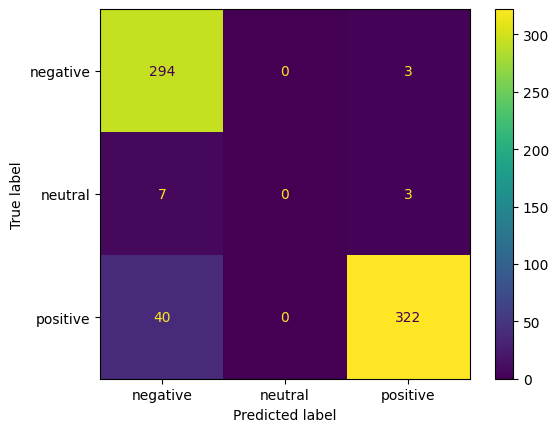

In [13]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.plot()

Annoyingly, first time I ran it, both negatives and positives were firmly yellow, but that was with a random seed, so now I can't reproduce it.

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.86      0.99      0.92       297
     neutral       0.00      0.00      0.00        10
    positive       0.98      0.89      0.93       362

    accuracy                           0.92       669
   macro avg       0.61      0.63      0.62       669
weighted avg       0.91      0.92      0.91       669



c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
model.score(vectorizer.transform(X_test), y_test)

0.9207772795216741

Aside from the fact that it failed to correctly label any neutral samples, of which there were only 11, it proved a lot more accurate than the Dacy model at predicting negatives. This is largely because it didn't predict any neutral sentiments at all.

The percentage of positives falsely classified as negatives is roughly the same as with Dacy.

There are still samples being misclassified, but this may be acceptable.